# Script to extract SRTM elevations over study sites through Google Earth Engine (GEE)

Adapted from [2022 ICESat Hackweek notebook](https://github.com/ICESAT-2HackWeek/website2022/blob/main/book/tutorials/DataVisualization/Visualization_Earth_Engine_geemap_IS2_HW_2022.ipynb)

To-Do:
- adjust to account for different beams in different ATL files
- use xarray to save information for each ICESat-2 track?
- separate elevation difference calculations by study area and/or track (biases could be different)
- plot elevations in map view

In [1]:
# !pip install contextily

In [2]:
import os
import ee
import pandas as pd
import geopandas as gpd
import geemap
import numpy as np
import contextily as ctx
from IPython.display import Image
import matplotlib.pyplot as plt
import h5py
from rasterio import plot, warp

In [3]:
# -----GEE Authentication and Initialization
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

### Extract SRTM elevations for AOI #1: Grand Mesa, CO

In [4]:
# -----Create geojson AOI
# used geojson.io
AOI1 = ee.Geometry({"type": "Polygon","coordinates": 
                    [[[-108.24005126953124,38.884619201291905],
                      [-107.9,38.884619201291905],
                      [-107.9,39.11727568585598],
                      [-108.24005126953124,39.11727568585598],
                      [-108.24005126953124,38.884619201291905]]
                    ]})

# -----Query for SRTM, clip to AOI
SRTM1 = ee.Image("USGS/SRTMGL1_003").clip(AOI1)

# -----Plot elevations
# from: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
SRTM1_url = SRTM1.getThumbUrl({
    'min': 0, 'max': 6000,
    'palette': ['white', 'green']})
Image(url=SRTM1_url)

### Extract SRTM elevations for AOI #2: Mores Creek Summit, ID

In [5]:
# -----Create geojson AOI
# used geojson.io
AOI2 = ee.Geometry({
        "type": "Polygon",
        "coordinates": [[[-115.74131011962889,43.8855215890078],
                         [-115.61874389648438,43.8855215890078],
                         [-115.61874389648438,43.963661859597536],
                         [-115.74131011962889,43.963661859597536],
                         [-115.74131011962889,43.8855215890078]
                        ]]})

# -----Query for SRTM clip to AOI
SRTM2 = ee.Image("USGS/SRTMGL1_003").clip(AOI2)

# -----Plot elevations
# from: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
SRTM2_url = SRTM2.getThumbUrl({
    'min': 0, 'max': 6000,
    'palette': ['white', 'green']})
Image(url=SRTM2_url)

### Load ICESat-2 "snow-off" track

In [6]:
# -----load file (downloaded using icesat2_query_download.ipynb)
data_path = '/home/jovyan/data/'
is2_file = 'processed_ATL08_20200920013522_13240806_005_01.h5' # Sept = snow-off 

with h5py.File(data_path+is2_file, 'r') as f:
    # load just one beam
    is2_gt2l = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                 'lon': f['gt2l/land_segments/longitude'][:],
                                  'h_te_best_fit': f['gt2l/land_segments/terrain/h_te_best_fit'][:]})

# -----function to convert Pandas gdf to ee.FeatureCollection
# from: https://bikeshbade.com.np/tutorials/Detail/?title=Geo-pandas%20data%20frame%20to%20GEE%20feature%20collection%20using%20Python&code=13
from functools import reduce
def feature2ee(gdf):
    g = [i for i in gdf.geometry]
    features=[]
    #for Point geo data type
    if (gdf.geom_type[0] == 'Point'):
        for i in range(len(g)):
            g = [i for i in gdf.geometry]
            x,y = g[i].coords.xy
            cords = np.dstack((x,y)).tolist()
            double_list = reduce(lambda x,y: x+y, cords)
            single_list = reduce(lambda x,y: x+y, double_list)
            g=ee.Geometry.Point(single_list)
            feature = ee.Feature(g)
            features.append(feature)
        ee_object = ee.FeatureCollection(features)
        return ee_object
    
# -----convert it to a Pandas GeoDataFrame (gdf)
is2_gdf = gpd.GeoDataFrame(is2_gt2l, geometry=gpd.points_from_xy(is2_gt2l.lon, is2_gt2l.lat), crs='epsg:7661')
is2_gdf.head()

,lat,lon,h_te_best_fit,geometry
0,43.937279,-115.664154,1867.905884,POINT (-115.66415 43.93728)
1,43.936382,-115.664284,1824.602539,POINT (-115.66428 43.93638)
2,43.935486,-115.664406,1801.802979,POINT (-115.66441 43.93549)
3,43.934586,-115.664528,1810.246460,POINT (-115.66453 43.93459)
4,43.933689,-115.664642,1814.206665,POINT (-115.66464 43.93369)


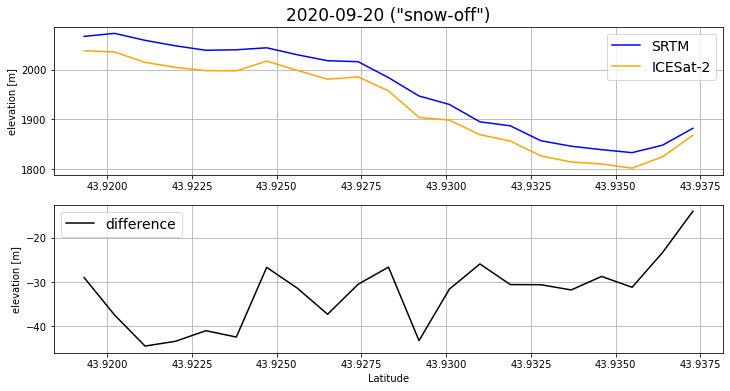

/srv/conda/envs/notebook/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 0 - 13).
  warnings.warn(msg)


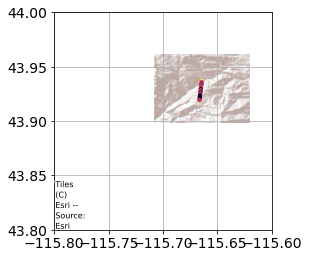

figures saved to file


In [7]:
# -----convert ICESat-2 gdf to ee.FeatureCollection (to sample the SRTM ee.Image at the coordinates)
is2_ee = feature2ee(is2_gdf)
is2_ee.getInfo(); # use this command (without semicolon) to output info

# -----sample SRTM elevation at ICESat-2 coordinates
SRTM2_sample = ee.FeatureCollection(SRTM2.sample(is2_ee))
SRTM2_sample_gdf = geemap.ee_to_geopandas(SRTM2_sample, selectors=['elevation'])
SRTM2_sample_gdf['lon'] = is2_gdf['lon']
SRTM2_sample_gdf['lat'] = is2_gdf['lat']

# -----calculate elevation difference
snow_off_diff = is2_gdf['h_te_best_fit'] - SRTM2_sample_gdf['elevation']

# -----plot
# SRTM & ICESat-2 elevations
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
ax1.plot(SRTM2_sample_gdf['lat'], 
         SRTM2_sample_gdf['elevation'], color='blue', label='SRTM')
ax1.plot(SRTM2_sample_gdf['lat'],
         is2_gdf['h_te_best_fit'], color='orange', label='ICESat-2')
ax1.set_ylabel('elevation [m]')
ax1.set_title('2020-09-20 ("snow-off")')
ax1.grid()
ax1.legend()
# elevation difference
ax2.plot(SRTM2_sample_gdf['lat'], snow_off_diff, color='black', label='difference')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('elevation [m]')
ax2.legend()
ax2.grid()
plt.show()

# Map view
fig2, axC = plt.subplots(1, 1)
axC.scatter(SRTM2_sample_gdf['lon'], SRTM2_sample_gdf['lat'], s=10, c = snow_off_diff, cmap=plt.cm.inferno)
ctx.add_basemap(ax=axC, crs=is2_gdf.crs, source=ctx.providers.Esri.WorldShadedRelief) 
axC.grid()
axC.set_xlim(-115.8, -115.6)
axC.set_ylim(43.8, 44)
plt.show()

# -----save figure
fig1.savefig('../figures/snow_free_profile_SRTM_processed_ATL08_20200920013522_13240806_005_01.png',dpi=200)
fig2.savefig('../figures/snow_free_profile_MAP_SRTM_processed_ATL08_20200920013522_13240806_005_01.png',dpi=200)
print('figures saved to file')

🛑 👇 The next section needs to be fixed! Elevation differences are huge...

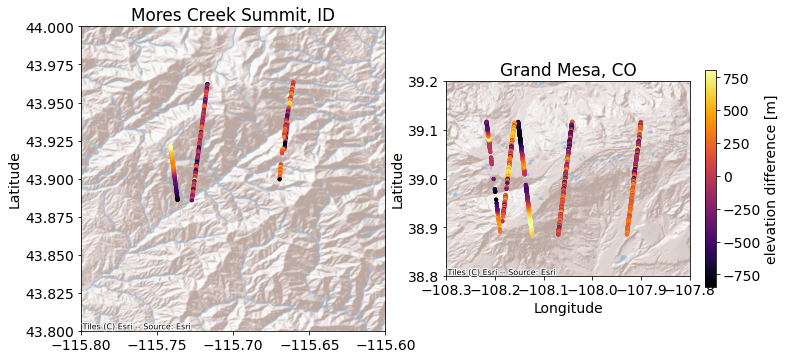

figure saved to file


In [8]:
# -----calculate elevation difference for other ICESat-2 tracks 

# grab ICESat-2 file names from directory
file_names = sorted(os.listdir(data_path))

# set up figure
fig2, (axA, axB) = plt.subplots(1, 2, figsize=(12, 10))
plt.rcParams.update({'font.size': 14, 'font.serif': 'Arial'})
# Grand Mesa, CO
axA.set_ylabel('Latitude')
axA.set_xlim(-115.8, -115.6)
axA.set_ylim(43.8, 44)
axA.set_title('Mores Creek Summit, ID')
# Mores Creek Summit, ID
# axB.set_xlabel('Longitude')
axB.set_ylabel('Latitude')
axB.set_xlabel('Longitude')
axB.set_xlim(-108.3, -107.8)
axB.set_ylim(38.8, 39.2)
axB.set_title('Grand Mesa, CO')
# line plotting colormap
colors = plt.cm.PuOr(np.linspace(0,1,len(file_names)+1))

# loop through files
for file_name in file_names:
        
    # extract date from file name
    date = file_name[16:24]
    
    # load file
    with h5py.File(data_path+file_name, 'r') as f:
        
        # check which beams are contained within file (not every file has both beams)
        if 'gt2l' in f:
            
            is2_gt2l = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                      'lon': f['gt2l/land_segments/longitude'][:],
                                      'h_te_best_fit': f['gt2l/land_segments/terrain/h_te_best_fit'][:]})
            
            # convert is2 to a geodataframe
            is2_gdf = gpd.GeoDataFrame(is2_gt2l, geometry=gpd.points_from_xy(is2_gt2l.lon, is2_gt2l.lat), crs='epsg:7661')
            # convert is2 gdf to ee.FeatureCollection
            is2_ee = feature2ee(is2_gdf)
            # sample SRTM elevation at ICESat-2 coordinates
            # SRTM1
            SRTM1_sample = ee.FeatureCollection(SRTM1.sample(is2_ee))
            SRTM1_sample_gdf = geemap.ee_to_geopandas(SRTM1_sample, selectors=['elevation'])
            SRTM1_sample_gdf['lon'] = is2_gdf['lon']
            SRTM1_sample_gdf['lat'] = is2_gdf['lat']
            # SRTM2
            SRTM2_sample = ee.FeatureCollection(SRTM2.sample(is2_ee))
            SRTM2_sample_gdf = geemap.ee_to_geopandas(SRTM2_sample, selectors=['elevation'])
            SRTM2_sample_gdf['lon'] = is2_gdf['lon']
            SRTM2_sample_gdf['lat'] = is2_gdf['lat']
             # determine which one applies
            if 'elevation' in SRTM1_sample_gdf.columns:
                SRTM_sample_gdf = SRTM1_sample_gdf
            elif 'elevation' in SRTM2_sample_gdf.columns:
                SRTM_sample_gdf = SRTM2_sample_gdf
    
            # calculate elevation difference
            diff = is2_gdf['h_te_best_fit'] - SRTM_sample_gdf['elevation']

            # plot elevation difference
            axA.scatter(is2_gdf['lon'], is2_gdf['lat'], s= 10, c = diff, cmap=plt.cm.inferno)
            axB.scatter(is2_gdf['lon'], is2_gdf['lat'], s= 10, c = diff, cmap=plt.cm.inferno)
            
        if 'gt2r' in f:
            
            is2_gt2r = pd.DataFrame(data={'lat': f['gt2l/land_segments/latitude'][:],
                                      'lon': f['gt2l/land_segments/longitude'][:],
                                      'h_te_best_fit': f['gt2l/land_segments/terrain/h_te_best_fit'][:]})
            
            # convert is2 to a geodataframe
            is2_gdf = gpd.GeoDataFrame(is2_gt2r, geometry=gpd.points_from_xy(is2_gt2l.lon, is2_gt2l.lat), crs='epsg:7661')
            # convert is2 gdf to ee.FeatureCollection
            is2_ee = feature2ee(is2_gdf)
            # sample SRTM elevation at ICESat-2 coordinates
            # SRTM1
            SRTM1_sample = ee.FeatureCollection(SRTM1.sample(is2_ee))
            SRTM1_sample_gdf = geemap.ee_to_geopandas(SRTM1_sample, selectors=['elevation'])
            SRTM1_sample_gdf['lon'] = is2_gdf['lon']
            SRTM1_sample_gdf['lat'] = is2_gdf['lat']
            # SRTM2
            SRTM2_sample = ee.FeatureCollection(SRTM2.sample(is2_ee))
            SRTM2_sample_gdf = geemap.ee_to_geopandas(SRTM2_sample, selectors=['elevation'])
            SRTM2_sample_gdf['lon'] = is2_gdf['lon']
            SRTM2_sample_gdf['lat'] = is2_gdf['lat']
             # determine which one applies
            if 'elevation' in SRTM1_sample_gdf.columns:
                SRTM_sample_gdf = SRTM1_sample_gdf
            elif 'elevation' in SRTM2_sample_gdf.columns:
                SRTM_sample_gdf = SRTM2_sample_gdf
    
            # calculate elevation difference
            diff = is2_gdf['h_te_best_fit'] - SRTM_sample_gdf['elevation']

            # plot elevation difference
            axA.scatter(is2_gdf['lon'], is2_gdf['lat'], s=10, c = diff, cmap=plt.cm.inferno)
            points = axB.scatter(is2_gdf['lon'], is2_gdf['lat'], s=10, c = diff, cmap=plt.cm.inferno)
    
# axB.legend(bbox_to_anchor=(1.25, 1.8))
ctx.add_basemap(ax=axA, crs=is2_gdf.crs, source=ctx.providers.Esri.WorldShadedRelief) 
ctx.add_basemap(ax=axB, crs=is2_gdf.crs, source=ctx.providers.Esri.WorldShadedRelief) 
fig2.colorbar(points, ax=axB, label='elevation difference [m]', shrink=0.4)
plt.show()

# save figure
fig2.savefig('../figures/SRTM_elev_diff.png', dpi=200)
print('figure saved to file')

In [9]:
# -----create a GEE map
# Map = geemap.Map()
# Map.addLayer(AOI1)
# Map.addLayer(AOI2)
# Map.addLayer(SRTM2, {min:1000, max:3000})
# Map.addLayer(SRTM1, {min:1000, max:3000})
# Map.addLayer(is2_ee)
# Map.centerObject(AOI2, zoom=12)
# Map